In [1]:
from visualizer import calibration
#TODO: import from waveorder
import visual 
from PyQt5 import QtCore
from skimage.io.collection import alphanumeric_key
from dask import delayed
from glob import glob
import dask.array as da
import matplotlib.pyplot as plt
import numpy as np
import napari
from napari import Viewer
import os
import tifffile
import cv2 as cv
import zarr
import cupy as cp 
from apeer_ometiff_library import io

%gui qt 
%matplotlib inline
plt.style.use('dark_background')

#Imported from Waveorder
from waveorder.io.multipagetiff import  MicromanagerOmeTiffReader
from aicsimageio import AICSImage,imread, imread_dask

from skimage.registration import phase_cross_correlation

The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
## Open Napari Viewer
viewer = napari.Viewer()

Assistant skips harvesting pyclesperanto as it's not installed.


c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


In [3]:
### Enter the filepath for the data directory


# main_dir =r'F:\DATA\20220507_M25_ZW495_9'   #5 Great dinamics in FOV for all the cameras.
main_dir =r'F:\Test_ignore\20220509_M25_oh15265_23'   #5 fast dynamics of big worm
###Enter the filepath for background images
bg_dir = r'F:\Test_ignore\20220513_M25_bg_16bit'
### Enter the filepath for Calibration Dataset (PSF) or offset file
psf_dir = r'F:\Test_ignore\220508_190nmSteps_postitive2negative_1'
# psf_dir = r'F:\Test_ignore\220508_380nmSteps_minusplus_reversed_1'
#Get Folders and files
main_dirs = sorted(glob(main_dir + '/CAM*/'), key=alphanumeric_key)
bg_folders = sorted(glob(bg_dir + '/CAM*/'), key=alphanumeric_key)

# Load offsets from desired folder 
processed_files = main_dir + '/'+'processed_files'
if not os.path.exists(processed_files):
    os.makedirs(processed_files)

offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets.csv")
offsets_file_best = os.path.join(offset_dir,"offsets_best.csv")

if os.path.exists(offsets_file):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")

## Quick Visualizer of the selected planes
# center_planes = calibration.lazy_dask_stack(main_dir,num_cams=5,px_depth='uint16', height=608, width =608)
# napari.add_image(center_planes, name='center_planes',scale=[z_scale,1,1],multiscale=False)

In [4]:
# Scope Parameters
cam_px = 6.0e-6
totalmag = 15.75
zstep = 2e-6

px_size_img = cam_px/totalmag
z_scale = zstep/px_size_img

### Loading Dataset

In [5]:
%%time
# stack = calibration.lazy_dask_stack(main_dir,num_cams=25,px_depth='uint8', height=600, width =960)
stack = calibration.lazy_dask_stack(main_dir,num_cams=25,px_depth='uint16', height=608, width =608)

CPU times: total: 5.02 s
Wall time: 5.24 s


In [6]:
viewer.add_image(stack,name='stack',scale=[z_scale,1,1], multiscale=False )

<Image layer 'stack' at 0x17578822af0>

### Get Background Images for subtraction
Get the series of background images to get rid of hot pixels and readout noise

In [7]:
#TODO: get background images of the whole sensor not just the croped region and at 16 bit
bg_stack = calibration.lazy_dask_stack(bg_dir,num_cams=25,px_depth='uint16', height=608, width =608)
bg_mean_stack = da.mean(bg_stack,axis=0).compute()

In [8]:
with cp.cuda.Device(0):
    stack_noBg = []
    t,c,h,w = stack.shape
    for i in range(c):
        cp_stack = cp.array(stack[:,i,:,:],dtype=float)
        bg_stack = cp.array(bg_mean_stack[i],dtype=float)
        # cp_stack = cp_stack - bg_stack
        cp_stack = cp.subtract(cp_stack,bg_stack)
        stack_noBg.append(cp.asnumpy(cp_stack.astype(np.uint16)))
        cp_stack = None
    stack_noBg = np.array(stack_noBg)
stack_noBg =  np.moveaxis(stack_noBg,0,1)

stack = stack_noBg
#Convert numpy to dask?
viewer.add_image(stack, name='no_bg',scale=[z_scale,1,1], multiscale=False)

<Image layer 'no_bg' at 0x17575db7670>

### Get Calibration from Bead's Files

In [6]:
filename = '220508_190nmSteps_postitive2negative_1_MMStack_Pos0.ome.tif'
# filename = '220508_380nmSteps_minusplus_reversed_1_MMStack_Pos0.ome.tif'
psf_file = os.path.join(psf_dir,filename)

In [7]:
(psf_stack_full, omexml) = io.read_ometiff(psf_file)
psf_stack_full= np.squeeze(psf_stack_full)

#TODO: Acquire backgroudn for the whole sensor
psf_stack = psf_stack_full[:,:,:,100:708]

In [8]:
# Generate our own shifted datset
with cp.cuda.Device(0):
    # test = stack[:,11:15,:,:]
    test = psf_stack
    t,c,h,w  = test.shape
    np_mip =[]
    for i in range(c):
        cp_stack = cp.array(test[:,i,:,:])
        cp_mip = cp.max(cp_stack, axis=0)
        # bg_stack = cp.array(bg_mean_stack[i,:,:])
        # cp_mip = cp.subtract(cp_mip,bg_stack)
        np_mip.append(cp.asnumpy(cp_mip))
        cp_mip = None
        cp_stack=None
    np_mip = np.array(np_mip)
    np_mip = np.expand_dims(np_mip,axis=0)

# Show the maximum intensity projection
# viewer = napari.Viewer()
viewer.add_image(np_mip, name='mip')

<Image layer 'mip' at 0x2112540a8b0>

In [9]:
a = np_mip[0,2]
print(a.shape)
x,y =np.where(a==a.max())
print(np.where(a==a.max()))
print(a.max())
print(x,y)
x = x[0]
y= y[0]
np_mip[0,2,x-2:x+2,y-2:y+2]=1500
# np_mip[0,2,x-2:x+2,y-2:y+2]
print(x+2)

(608, 608)
(array([284], dtype=int64), array([277], dtype=int64))
18400
[284] [277]
286


In [11]:
def registration(img_stack,ref_index):
    t,c,h,w =img_stack.shape
    stack_max_projection= np.array([ da.max(img_stack[:,i,:,:],axis=0) for i in range(img_stack.shape[1])])
    offset = np.array([phase_cross_correlation(stack_max_projection[ref_index], stack_max_projection[i],upsample_factor=1000) for i in range(stack_max_projection.shape[0])],dtype=object)
    offset = offset[0:c,0]
    offset_coords = np.stack(offset[0:,],axis=0)
    return offset_coords

In [12]:
offset_coords = registration(np_mip,0)
#Aligning Max Projection to check if coordinates are good
from cupyx.scipy.ndimage import shift
import cupy as cp
# Generate our own shifted datset
with cp.cuda.Device(0):
    mip_aligned = []
    t,c,h,w = psf_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    columns = cp.zeros((offset_coords.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offset_coords))
    print(shift_stack_coord.shape)
    print(np_mip.shape)
    for i in range(c):
        cp_stack = cp.array(np_mip[:,i,:,:])
        shift_stack_cam= shift(cp_stack,shift_stack_coord[i])
        mip_aligned.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    mip_aligned = np.array(mip_aligned)
mip_aligned =  np.moveaxis(mip_aligned,0,1)

#Convert to Dask Array
mip_aligned = da.from_array(mip_aligned)

# Check for alignment using the MIP. If so then proceed to next cell
viewer.add_image(mip_aligned, name='MIP_aligned2',scale = [z_scale,1,1])

np.savetxt(offsets_file, offset_coords, delimiter=',')

print(offset_coords)

(25, 3)
(1, 25, 608, 608)
[[  0.      0.   ]
 [-33.536 -33.192]
 [-95.851 -11.014]
 [-11.75  -94.725]
 [-27.743 -67.494]
 [ 70.489 -13.71 ]
 [ 10.706 -12.49 ]
 [ 29.17  -47.612]
 [-15.641 -99.813]
 [-16.05  -23.223]
 [  6.515   2.845]
 [ 15.282 -54.243]
 [ 33.422 -49.664]
 [ -4.691 -60.707]
 [ 25.15  -43.891]
 [ 12.934 -44.67 ]
 [ 17.037 -51.671]
 [ 31.733 -61.127]
 [ -9.157 -44.407]
 [ 15.719 -52.411]
 [ 20.297 -36.251]
 [ 56.124 -12.136]
 [ 50.961 -41.182]
 [ 16.537 -30.841]
 [ 37.748 -48.261]]


In [53]:

#Go to napari and make a square for alignment
crop_region =viewer.layers['Shapes'].data[0]
template = calibration.create_box_ndarray(crop_region)
template_box = template[0:4,2:4]

# Since OpenCV Match Template takes in uint8 || float32. We can change from uint16 to uint8 easily
np_mip_8bit =visual.im_bit_convert(np_mip,bit=8,norm=True)
min_val, max_val = template_box
t,c = template[0,0:2]
crop_img = np_mip_8bit[t,c, min_val[0]:max_val[0],min_val[1]:max_val[1]]
coord =[]
for i in range(c):
    xyz,error,phasediff = register_translation(np_mip_8bit[:,i,min_val[0]:max_val[0],min_val[1]:max_val[1]],crop_img,upsample_factor=1)
    coord.append(xyz)
print(np.array(coord))

NameError: name 'register_translation' is not defined

In [24]:
#Go to napari and make a square for alignment
crop_region =viewer.layers['Shapes'].data[0]
template = calibration.create_box_ndarray(crop_region)
template_box = template[0:4,2:4]

# Since OpenCV Match Template takes in uint8 || float32. We can change from uint16 to uint8 easily
np_mip_8bit =visual.im_bit_convert(np_mip,bit=8,norm=True)
min_val, max_val = template_box
t,c = template[0,0:2]
crop_img = np_mip_8bit[t,c, min_val[0]:max_val[0],min_val[1]:max_val[1]]
# viewer.add_image(crop_img,name='crop')

### Perform the actual registration with the chosen method. Look at documentation for other methods..
# TODO: Add capability to select whatever method we want. 
coord =[]
w,h = template.shape  
methods = 'cv.TM_CCOEFF'
# print(w,h)
t,c,h,w = np_mip_8bit.shape

for i in range(c):
    method = eval(methods) # This method parses expression and runs ()
    # Apply template Matching
    # Slide through image and compare template patches.
    # Comparison of best matches is foudn as global minn in SQDIFF or max in CCORR or CCOEF.
    res = cv.matchTemplate(np_mip_8bit[0,i,:,:],crop_img,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
        
    bottom_right = (top_left[0] + w, top_left[1] + h)
    #Output would contain the Top left corner and bottom right in case of need to use this rectangle
    coord.append(((top_left[1],top_left[0]),(bottom_right[1],bottom_right[0])))

#For the bead calibration we only use the TL points for alignment
TL_coords = np.array(coord)
TL_coords= TL_coords[0:25,0]

#Coordinates need to then be subtracted to the reference frame (i.e t,c for which rectangle was drawn)
res = []
ref_cam_index = 0
# diff =[]
for i,coordinate in enumerate(TL_coords):
    val = tuple(map(lambda i, j: i - j, TL_coords[ref_cam_index],coordinate))
    res.append(val)

offset_coordinates = np.array(res)
#Save the Offsets in the folder
np.savetxt(offsets_file, offset_coordinates, delimiter=',')

#Aligning Max Projection to check if coordinates are good
from cupyx.scipy.ndimage import shift
import cupy as cp
# Generate our own shifted datset
with cp.cuda.Device(0):
    mip_aligned = []
    t,c,h,w = psf_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    columns = cp.zeros((offset_coordinates.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offset_coordinates))
    print(shift_stack_coord.shape)
    print(np_mip.shape)
    for i in range(c):
        cp_stack = cp.array(np_mip[:,i,:,:])
        shift_stack_cam= shift(cp_stack,shift_stack_coord[i])
        mip_aligned.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    mip_aligned = np.array(mip_aligned)
mip_aligned =  np.moveaxis(mip_aligned,0,1)

#Convert to Dask Array
mip_aligned = da.from_array(mip_aligned)

# Check for alignment using the MIP. If so then proceed to next cell
viewer.add_image(mip_aligned, name='MIP_aligned',scale = [z_scale,1,1])

(25, 3)
(1, 25, 608, 608)


<Image layer 'MIP_aligned' at 0x1619783c130>

In [9]:
#Aligning all the stack after looking at the MIP stack
from cupyx.scipy.ndimage import shift
import cupy as cp
# Generate our own shifted datset
with cp.cuda.Device(0):
    stack_aligned = []
    t,c,h,w = psf_stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    columns = cp.zeros((offset_coordinates.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offset_coordinates))
    print(shift_stack_coord.shape)
    print(stack.shape)
    for i in range(c):
        cp_stack = cp.array(stack[:,i,:,:])
        shift_stack_cam= shift(cp_stack,shift_stack_coord[i])
        stack_aligned.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    stack_aligned = np.array(stack_aligned)
stack_aligned =  np.moveaxis(stack_aligned,0,1)

#Convert to Dask Array
stack_aligned = da.from_array(stack_aligned)
viewer.add_image(stack_aligned, name='test',scale = [z_scale,1,1])

(25, 3)


NameError: name 'stack' is not defined

### Align Datasets with Known Offsets


(735, 25, 608, 608)
CPU times: total: 0 ns
Wall time: 0 ns


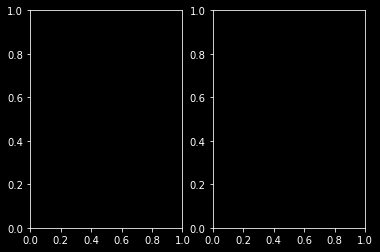

In [24]:
# from dask.distributed import Client, LocalCluster
# from dask_image.ndinterp import ndimage_affine_transform
# # cluster = LocalCluster()
# # client = Client(cluster)
# offset_coordinates = offsets_pcc
# t,c,h,w = stack.shape
# M_translation = da.eye(3)
# tx=offset_coordinates[1,0]
# ty=offset_coordinates[1,1]
# M_translation[0,2] = tx
# M_translation[1,2] = ty
# # print(M_translation)
# print(stack.shape)
# fig,ax = plt.subplots(1,2)
# result = ndimage_affine_transform(stack[1,1,:,:],M_translation)
# stack_aligned = da.zeros_like(stack)
# %time
# t=10
# # for i in range(t):
# #     stack_aligned[i,1,:,:] = ndimage_affine_transform(stack[i,1,:,:],M_translation)
# # viewer.add_image(stack_aligned[:10,1,:,:])

# # ax[0].imshow(stack[1,1,:,:])
# # ax[1].imshow(result)
# # ndimage_affine_transform(stack)


In [9]:
offset_dir = os.path.join(psf_dir + '/'+'processed_files')
offsets_file = os.path.join(offset_dir,"offsets_best.csv")
if os.path.exists(offset_dir):
    with open(offsets_file) as file_name:
        print("loading offsets")
        offsets = np.loadtxt(file_name, delimiter=",")
        # print(offsets)

loading offsets


In [10]:
from cupyx.scipy.ndimage import shift
# Generate our own shifted datset
offset_coordinates = offsets
with cp.cuda.Device(0):
    stack_aligned = []
    t,c,h,w = stack.shape
    shift_stack_cam = cp.zeros((c,h,w))
    columns = cp.zeros((offset_coordinates.shape[0],1))
    shift_stack_coord = cp.hstack((columns,offset_coordinates))
    print(shift_stack_coord.shape)
    print(stack.shape)
    for i in range(c):
        cp_stack = cp.array(stack[:,i,:,:])
        # bg_stack = cp.array(bg_mean_stack[i])
        # cp_stack = cp.subtract(cp_stack,bg_stack)
        shift_stack_cam= shift(cp_stack,shift_stack_coord[i])
        stack_aligned.append(cp.asnumpy(shift_stack_cam))
        cp_stack = None
    stack_aligned = np.array(stack_aligned)
stack_aligned =  np.moveaxis(stack_aligned,0,1)

#Convert numpy to dask?
center_cam_compensation = 1.4   #Taken from measurements
da_stack_align = da.from_array(stack_aligned)
da_stack_align[:,12,:,:]= da_stack_align[:,12,:,:]*center_cam_compensation
viewer.add_image(da_stack_align, name='dask_align',scale=[z_scale,1,1], multiscale=False)

(25, 3)
(735, 25, 608, 608)


<Image layer 'dask_align' at 0x17572b176d0>

#### SAVE TIFF ALIGNED

In [11]:
## Save in compressessed lossless format ZARR
import zarr
filename = 'aligned_stack' + '.zarr'
filepath_save = os.path.join(processed_files,filename)
print(filepath_save)
zarr.save(filepath_save,stack_aligned)

F:\Test_ignore\20220509_M25_oh15265_23/processed_files\aligned_stack.zarr


In [12]:
## Save in ome tiff files
import tifffile
filename = 'aligned_stack' + '.ome.tif'
filepath_save = os.path.join(processed_files,filename)
print(filepath_save)
tifffile.imsave(filepath_save,stack_aligned)

F:\Test_ignore\20220509_M25_oh15265_23/processed_files\aligned_stack.ome.tif


C:\Users\yoshi\AppData\Local\Temp\ipykernel_9340\4112802012.py:6: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tifffile.imsave(filepath_save,stack_aligned)


### ANALYSIS/"

In [92]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.zarr'
filepath_save = os.path.join(processed_files,filename)
zarr_stack = zarr.load(filepath_save)
da_zarr_stack = da.asarray(zarr_stack,dtype=np.float32)


In [93]:
zarr_stack.shape
zarr_stack[:,12,:,:]=zarr_stack[:,12,:,:]*1.23077

In [99]:
viewer.add_image(zarr_stack)

<Image layer 'zarr_stack' at 0x21f79c74670>

In [80]:
# a = da_zarr_stack[1,:,35:40,35:40]
# b = da_zarr_stack[2,:,35:40,35:40]
a = np.zeros((1,1,5,5))
b = np.ones((1,1,5,5))*2
c = np.hstack((a,b))
c = np.vstack((c,c))
print(c.shape)

d = np.sum(c[0,:,:,:])
print(d)


(2, 2, 5, 5)
50.0


(600, 25, 608, 608)


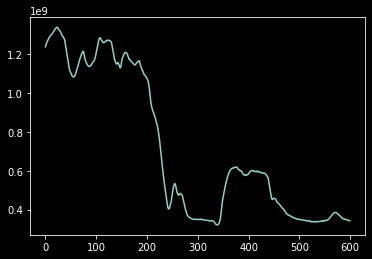

In [100]:
t,c,h,w  = da_zarr_stack.shape
print(da_zarr_stack.shape)
sum_per_volume =[]
# da_zarr_stack =da.Array.astype(dtype='float)
for dt in range(t):
    sum_per_volume.append(da.sum(da_zarr_stack[dt,:,:,:]).compute())

plt.figure()
plt.plot(sum_per_volume)


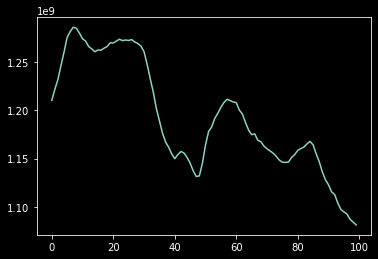

In [103]:
plt.plot(sum_per_volume[100:200])

In [107]:
kymo_zarr.shape

(600, 608, 25, 608)

In [108]:
kymo_zarr = da_zarr_stack.swapaxes(1,2)
kymo_zarr_sum = da.sum(kymo_zarr,axis=1)
viewer.add_image(kymo_zarr_sum)


<Image layer 'kymo_zarr_sum' at 0x21f6d891b80>

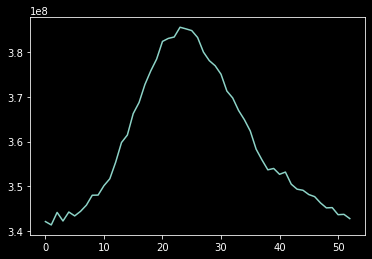

In [111]:
plt.plot(sum_per_volume[547:600])

In [ ]:
import scipy.ndimage as ndi

test= da_zarr_stack

In [97]:
#MIP for each timepoint
with cp.cuda.Device(0):
    t,c,h,w  = zarr_stack.shape
    print(zarr_stack.shape)
    zarr_stack_mip =[]
    for i in range(t):
        cp_stack = cp.array(zarr_stack[i,:,:,:])
        cp_mip = cp.max(cp_stack, axis=0)
        zarr_stack_mip.append(cp.asnumpy(cp_mip))
        cp_mip = None
        cp_stack=None
    zarr_stack_mip = np.array(zarr_stack_mip)
    zarr_stack_mip = np.expand_dims(zarr_stack_mip,axis=0)

(600, 25, 608, 608)


In [37]:
zarr_stack_mip.shape
kymo_zarr = zarr_stack_mip.swapaxes(1,2)
print(kymo_zarr.shape)
kymo_zarr_mip = np.max(kymo_zarr, axis = 1)
viewer.add_image(kymo_zarr_mip)

(1, 608, 600, 608)


<Image layer 'kymo_zarr_mip' at 0x21f758f4ca0>

(1, 600, 608)


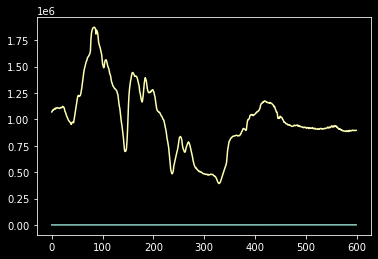

In [43]:
print(kymo_zarr_mip.shape)
_,t,x = kymo_zarr_mip.shape

kymo_sum=[]
for i in range(t):
    kymo_sum.append([i, np.sum(kymo_zarr_mip[0,i,:])])

plt.figure()
plt.plot(kymo_sum)    

1086086

### CROPPING Function for NAPARI
This can be used for getting smaller ROIs. Easiest way to run this is having stack layer and the created shapes layer to crop

In [9]:
#Go to napari and make a square for alignment
crop_region =viewer.layers['Shapes'].data[0]
template = calibration.create_box_ndarray(crop_region)
template_box = template[0:4,2:4]
min_val, max_val = template_box
t,c = template[0,0:2]
crop_img = da_stack_align[:,:, min_val[0]:max_val[0],min_val[1]:max_val[1]]

KeyError: "'Shapes' is not in list"

### Image J Part

In [3]:
### napari viewer must be st before running ImageJ. Viewer was probably called previously so uncomment if needed
# viewer= napari.Viewer()

In [35]:
def start_imagej():
    import imagej
    global ij
    ij = imagej.init( mode='interactive')
    # path = r'C:\Users\yoshi\Documents\Fiji.app'  #Uncomment and replace for FIJI filepath
    # ij = imagej.init(path,mode='interactive')     #Uncomment if using FIJI filepath    
    ij.ui().showUI()
    print(ij.getVersion())
QtCore.QTimer.singleShot(0, start_imagej())

ExecutableNotFound: mvn not found on path C:\ProgramData\Anaconda3\envs\m25-py39\Lib\site-packages\cv2\../../x64/vc14/bin;c:\ProgramData\Anaconda3\envs\m25-py39;C:\ProgramData\Anaconda3\envs\m25-py39;C:\ProgramData\Anaconda3\envs\m25-py39\Library\mingw-w64\bin;C:\ProgramData\Anaconda3\envs\m25-py39\Library\usr\bin;C:\ProgramData\Anaconda3\envs\m25-py39\Library\bin;C:\ProgramData\Anaconda3\envs\m25-py39\Scripts;C:\ProgramData\Anaconda3\envs\m25-py39\bin;C:\ProgramData\Anaconda3\condabin;C:\ProgramData\Anaconda3;C:\ProgramData\Anaconda3\Library\mingw-w64\bin;C:\ProgramData\Anaconda3\Library\usr\bin;C:\ProgramData\Anaconda3\Library\bin;C:\ProgramData\Anaconda3\Scripts;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.5\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v11.5\libnvvp;C:\Program Files\Basler\pylon 5\Runtime\x64;C:\Program Files\Basler\pylon 5\Runtime\Win32;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\bin;C:\Program Files\NVIDIA GPU Computing Toolkit\CUDA\v10.1\libnvvp;C:\Program Files\AdoptOpenJDK\jdk-8.0.232.09-hotspot\bin;C:\Program Files (x86)\Common Files\Oracle\Java\javapath;C:\Windows\system32;C:\Windows;C:\Windows\System32\Wbem;C:\Windows\System32\WindowsPowerShell\v1.0;C:\Windows\System32\OpenSSH;C:\Program Files\Git\cmd;C:\Program Files\Git\mingw64\bin;C:\Program Files\Git\usr\bin;C:\Program Files\MATLAB\R2019a\runtime\win64;C:\Program Files\MATLAB\R2019a\bin;C:\Program Files (x86)\NVIDIA Corporation\PhysX\Common;c:\Program Files (x86)\Microsoft SQL Server\110\Tools\Binn;c:\Program Files\Microsoft SQL Server\110\Tools\Binn;c:\Program Files\Microsoft SQL Server\110\DTS\Binn;C:\Program Files\NVIDIA Corporation\NVIDIA NvDLISR;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files (x86)\Windows Kits\10\Windows Performance Toolkit;C:\Program Files\Point Grey Research\Spinnaker\bin64\vs2015;C:\Program Files\Point Grey Research\Spinnaker\bin\vs2015;C:\Users\yoshi\.dnx\bin;C:\Program Files\Microsoft DNX\Dnvm;C:\Program Files\Microsoft SQL Server\130\Tools\Binn;C:\Program Files\Java\apache-ant-1.10.7\bin;C:\Program Files (x86)\Microsoft Emulator Manager\1.0;C:\WINDOWS\system32;C:\WINDOWS;C:\WINDOWS\System32\Wbem;C:\WINDOWS\System32\WindowsPowerShell\v1.0;C:\WINDOWS\System32\OpenSSH;C:\Program Files\NVIDIA Corporation\Nsight Compute 2021.3.1;C:\Program Files\PuTTY;C:\Program Files\dotnet;C:\Users\yoshi\AppData\Local\Microsoft\WindowsApps;C:\Users\yoshi\Documents\edhirata\ColorTool;C:\Program Files (x86)\Windows Kits\8.0\bin\x86;.;C:\Program Files\JetBrains\PyCharm Community Edition 2021.2.1\bin;.;C:\Users\yoshi\AppData\Local\Programs\Microsoft VS Code\bin;C:\Users\yoshi\.dotnet\tools

In [33]:
# Get ndarray and send to Java
ij_stack2  = ij.py.to_java(np.array(da_stack_align))
ij.ui().show('PSF', ij_stack2)

NameError: name 'ij' is not defined

In [16]:
# Get the Active Window in imageJ and send back to python
ij.WindowManager.getActiveWindow()
java_img =ij.WindowManager.getCurrentImage()
np_img = ij.py.from_java(java_img)
np_img = np.swapaxes(np_img,1,3)
da_img = da.asarray(np_img)
viewer.add_image(da_img, name='imageJ_img',scale=[z_scale,1,1],multiscale=False)

(60, 342, 413, 25)


#### Functions to save TIFF FIles

In [27]:
import tifffile
filename = 'aligned_stack' + '.ome.tif'
filepath_save = os.path.join(processed_files,filename)
print(filepath_save)
tifffile.imsave(filepath_save,np_img)

F:\Test_ignore\20220509_M25_oh15265_23/processed_files\aligned_stack.ome.tif


NameError: name 'np_img' is not defined

### Read TIFF FILE

In [5]:
viewer = napari.Viewer()

In [4]:
### For preexisting tiff saved datasets
filename = 'aligned_stack.ome.tif'
filepath_save = os.path.join(processed_files,filename)

In [5]:
# filename = 'crop_section' + '.ome.tif'
# filepath_save = os.path.join(main_folder,filename)

In [5]:
crop_tiff = tifffile.imread(filepath_save)
print(crop_tiff.shape)
print(type(crop_tiff))
da_crop_tiff = da.from_array(crop_tiff)

viewer.add_image(crop_tiff, name='crop',scale=[z_scale,1,1],contrast_limits=(0,2**16-1))

(600, 25, 608, 608)
<class 'numpy.ndarray'>


NameError: name 'viewer' is not defined

In [8]:
viewer= napari.Viewer()
viewer.add_image(crop_tiff, name='crop',scale=[z_scale,1,1],contrast_limits=(0,2**16-1))

c:\ProgramData\Anaconda3\envs\m25-py39\lib\site-packages\napari_tools_menu\__init__.py:168: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'crop' at 0x21cc7eb25b0>

In [9]:
# Align the files
ij_stack2  = ij.py.to_java(np.array(crop_tiff))
ij.ui().show('PSF', ij_stack2)

In [ ]:
ij.WindowManager.getActiveWindow()
a =ij.WindowManager.getCurrentImage()
anp = ij.py.from_java(a)
print(anp.shape)

In [8]:
from napari_animation import Animation
animation = Animation(viewer)
animation.animate('test.gif',canvas_only = False )

### ZARR IMPORT

In [12]:
main_folder = r'H:\Test\20220504_M25_celegansOH_late1'
file_name = main_folder + '/'+'deconvolved_worm' + '.zarr'
zarr_stack = zarr.load(file_name)
da_stack_deconvolved = da.from_array(zarr_stack)


In [14]:
viewer.add_image(da_stack_deconvolved, scale= [z_scale,1,1])

<Image layer 'da_stack_deconvolved [1]' at 0x1351614dbe0>

c:\Users\yoshi\Anaconda3\envs\napari-m25\lib\site-packages\numpy\core\numeric.py:2449: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())
c:\Users\yoshi\Anaconda3\envs\napari-m25\lib\site-packages\numpy\core\numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
c:\Users\yoshi\Anaconda3\envs\napari-m25\lib\site-packages\numpy\core\numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
c:\Users\yoshi\Anaconda3\envs\napari-m25\lib\site-packages\numpy\core\numeric.py:2443: FutureWarning: Private